### Global measures distributions in snapshots joint for treatments

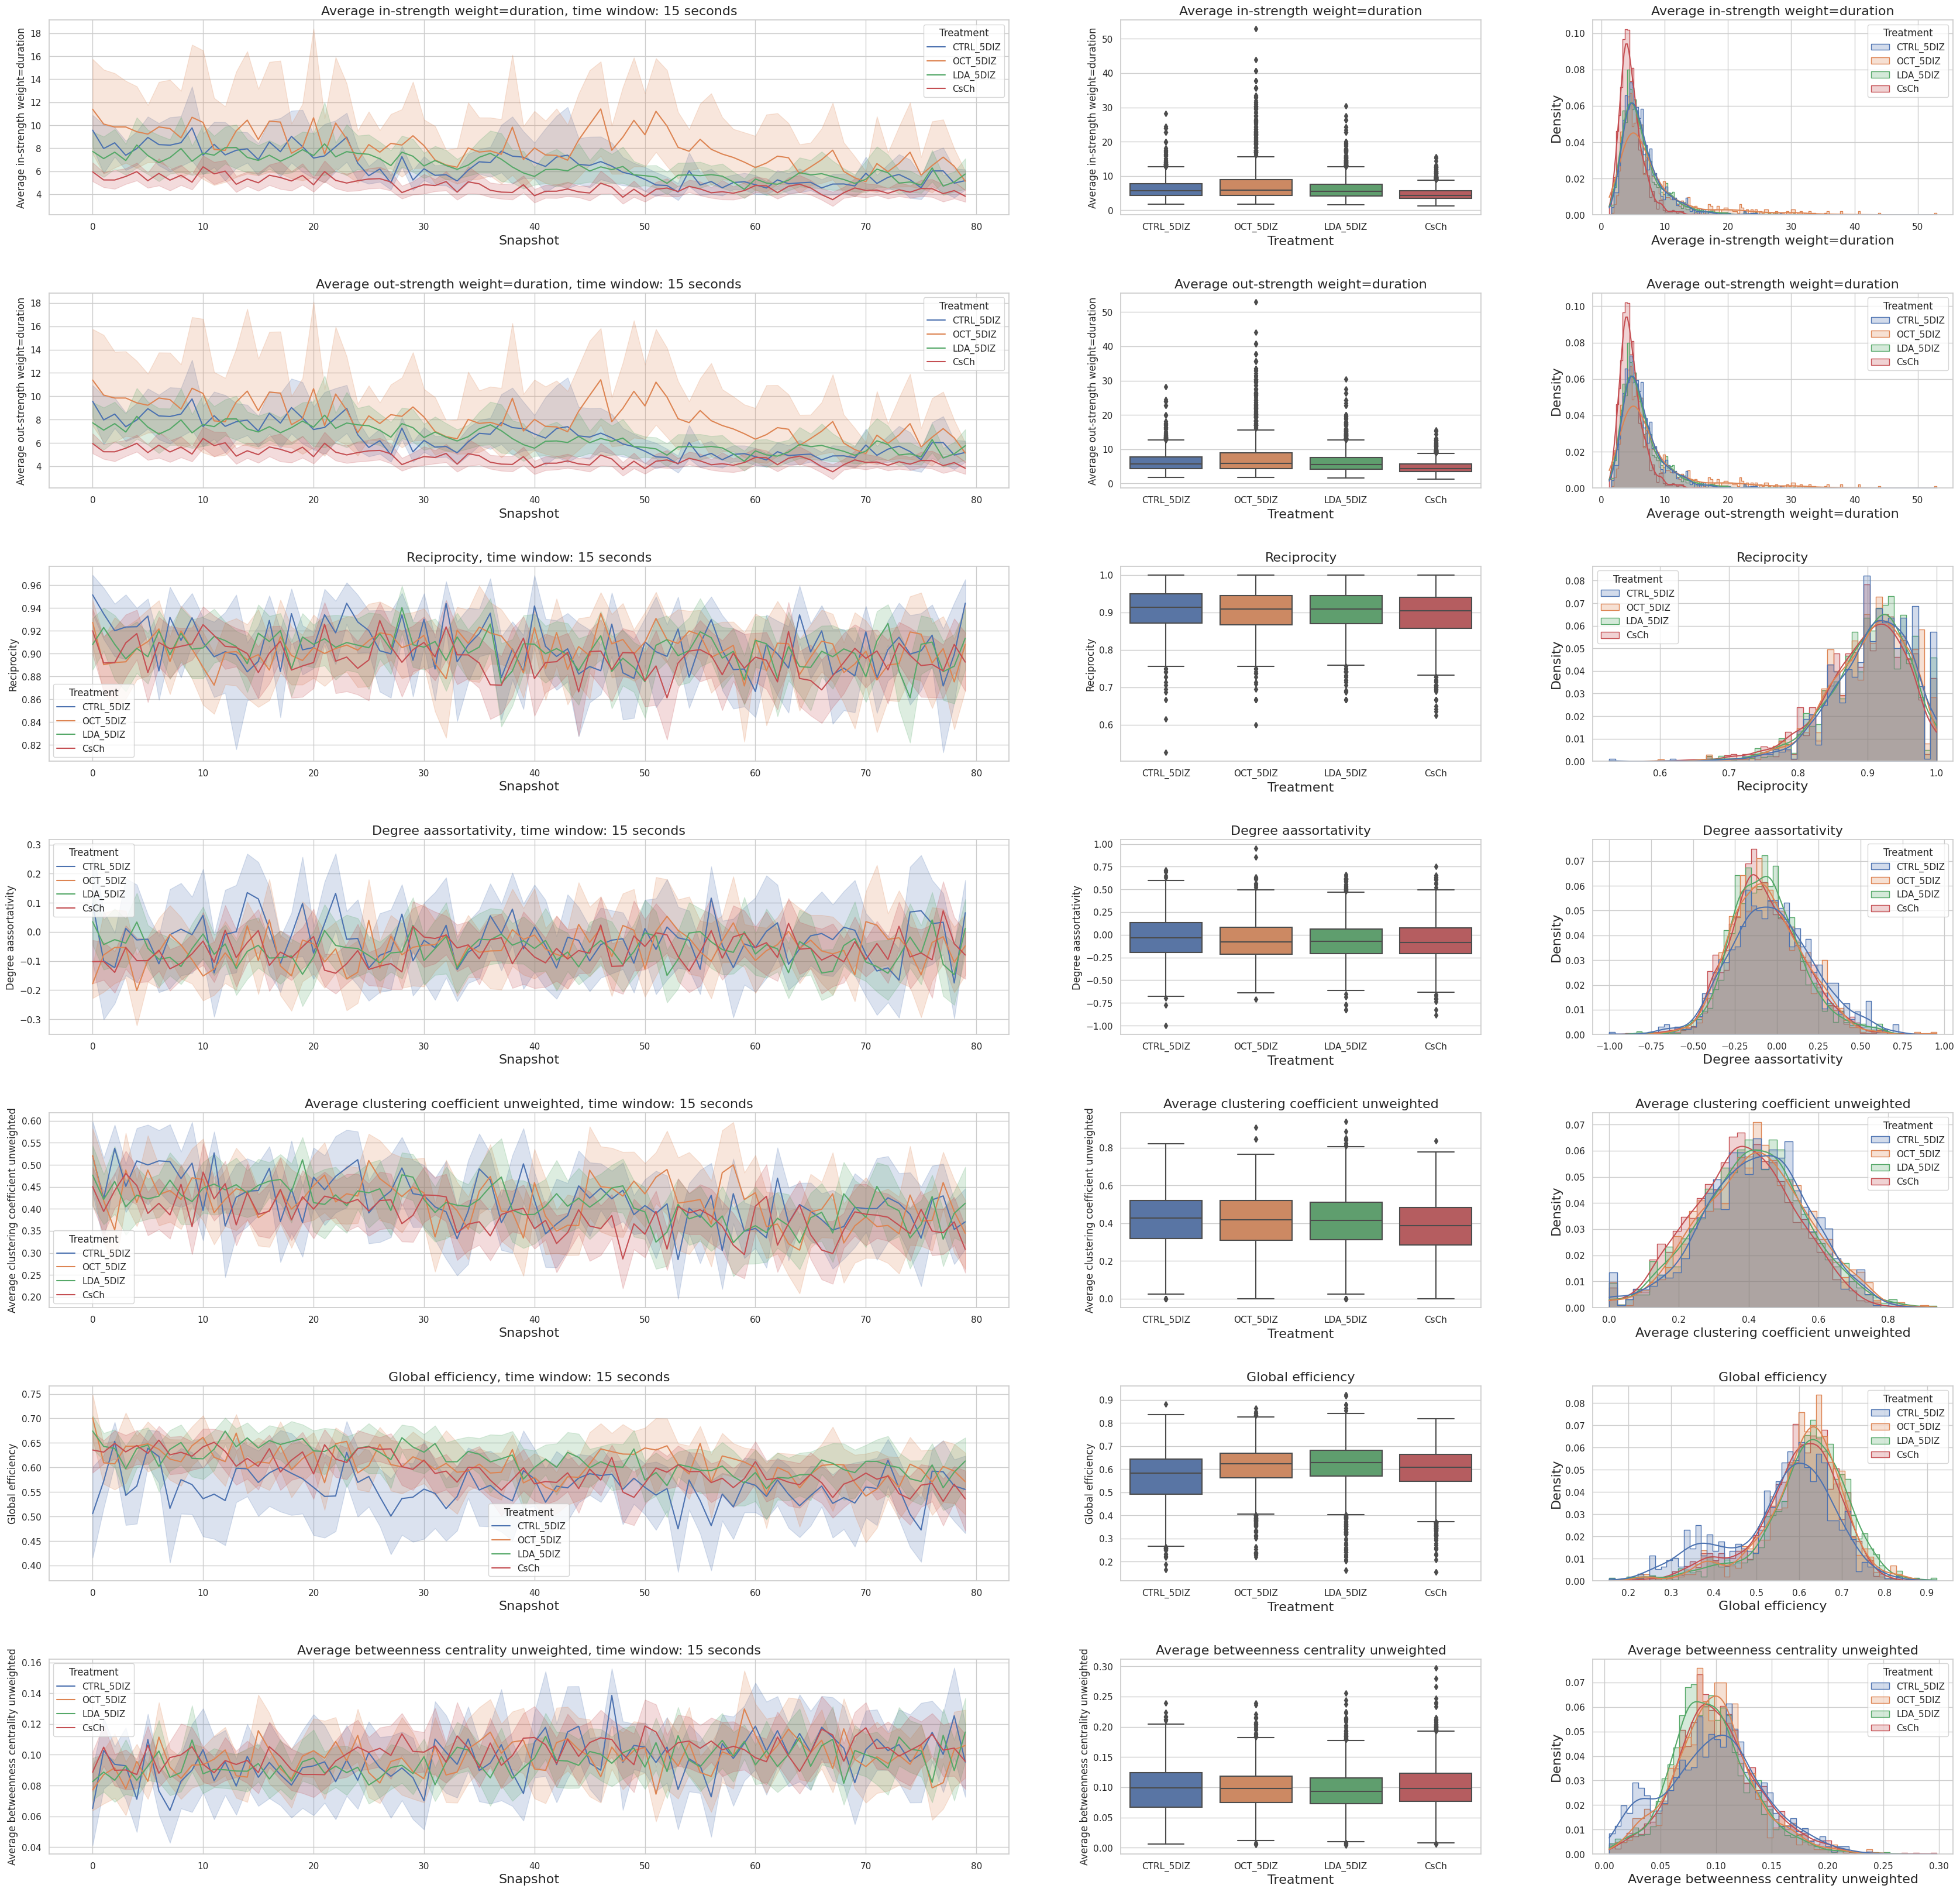

In [8]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import toml
from src import settings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)
TIME_WINDOW=config["TIME_WINDOW"]
INPUT_PATH = os.path.join(settings.RESULTS_DIR, "global_measures_snapshots", f"{TIME_WINDOW}_sec_window/")
all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)
    treatment_dataframes = []
    for group_name, df_path in all_groups.items():
        df = pd.read_csv(df_path, index_col=0)  
        df['Group'] = group_name
        treatment_dataframes.append(df)

    combined_df = pd.concat(treatment_dataframes)
    combined_df = combined_df.set_index(['Group'], append=True)
    combined_df.index.names = ['Snapshot', 'Group']
    combined_df = combined_df.reorder_levels(['Group', 'Snapshot'])
    combined_df['Treatment'] = treatment_name
    combined_df = combined_df.set_index('Treatment', append=True)
    dataframes.append(combined_df)

combined_data = pd.concat(dataframes)
combined_data_reset = combined_data.reset_index()

# # MIN_T = 40
# MAX_T = 80
# combined_data_reset = combined_data_reset.loc[(combined_data_reset['Snapshot'] > MAX_T)]

FONT_SIZE = 16
Y_LABEL_FONT_SIZE = 12
num_cols = 3
num_rows = len(combined_data.columns)

fig_main = plt.figure(figsize=(42, 6 * num_rows))
# fig_main.suptitle(f"Distribution of global measures for time window of {TIME_WINDOW} seconds", fontsize=30)

# measure_names = combined_data.columns.tolist()

combined_data_reset['Average in-strength weight=duration'] = combined_data_reset['Average in-strength weight=duration']/config["FPS"]
combined_data_reset['Average out-strength weight=duration'] = combined_data_reset['Average out-strength weight=duration']/config["FPS"]

measure_names = [
    'Average in-strength weight=duration',
    'Average out-strength weight=duration',
    'Reciprocity',
    'Degree aassortativity',
    'Average clustering coefficient unweighted',
    'Global efficiency',
    'Average betweenness centrality unweighted',
]
grid = plt.GridSpec(num_rows, num_cols, hspace=0.4, width_ratios=[16, 6, 6])
for i, measure_name in enumerate(measure_names):
    ax1 = plt.subplot(grid[i, 0])
    ax2 = plt.subplot(grid[i, 1])
    ax3 = plt.subplot(grid[i, 2]) 

    sns.set(style="whitegrid")
    sns.lineplot(data=combined_data_reset, x="Snapshot", y=measure_name, hue="Treatment", ax=ax1)
    ax1.set_xlabel("Snapshot", fontsize=FONT_SIZE)
    ax1.set_ylabel(measure_name, fontsize=Y_LABEL_FONT_SIZE)
    ax1.set_title(f'{measure_name}, time window: {TIME_WINDOW} seconds', fontsize=FONT_SIZE, loc='center')

    sns.boxplot(data=combined_data_reset, x="Treatment", y=measure_name, ax=ax2)
    ax2.set_xlabel("Treatment", fontsize=FONT_SIZE)
    ax2.set_ylabel(measure_name, fontsize=Y_LABEL_FONT_SIZE)
    ax2.set_title(f'{measure_name}', fontsize=FONT_SIZE, loc='center')

    sns.histplot(data=combined_data_reset, x=measure_name, hue="Treatment",
                 stat="probability", common_norm=False, element="step", kde=True, ax=ax3)
    ax3.set_xlabel(measure_name, fontsize=FONT_SIZE)
    ax3.set_ylabel('Density', fontsize=FONT_SIZE)
    ax3.set_title(f'{measure_name}', fontsize=FONT_SIZE, loc='center')

# plt.tight_layout()
plt.show()